<div style="background-color: lightblue; padding: 10px; border-radius: 5px; font-family: Aptos; ">
    <h1><b> Cultural Tourism Route Optimization </b></h1>


<ul>
    <li><b>Authored by:</b> Uvini Wijesinghe</li>
    <li><b>Duration:</b> 10 Weeks</li>
    <li><b>Level:</b> Intermediate</li>
    <li><b>Pre-requisite Skills:</b> Python</li>
</ul>

</div>
</div>

<div style="font-family: Aptos; font-size: 16px;">
Creating optimized cultural tourism routes in Melbourne involves integrating data from multiple sources, including public memorials, sculptures, artworks, fountains, monuments, and landmarks, along with key transport infrastructure such as City Circle tram stops and Melbourne Visitor Shuttle bus stops. By analyzing pedestrian movement patterns, the objective is to design routes that maximize visitor engagement by guiding them through high-interest cultural sites while ensuring accessibility and efficiency.
</div>

In [247]:
import pandas as pd

### Artworks, Fountains and Monuments

In [249]:
places = pd.read_csv("Datasets/public-artworks-fountains-and-monuments.csv")
places.head(2)

,Asset Type,Name,Xorg,Xsource,Address Point,Artist,Alternate Name,Art Date,Mel way Ref,Respective Author,Structure,Co-ordinates,Easting,Northing
0,Art,Port Phillip Monument,City of Melbourne,MCC - Ortho Image March 2005 - Final,"178 Sims Street, WEST MELBOURNE",unknown,NaN,1941,2S_K11,City Of Melbourne,Basalt monument,"-37.8056957854241, 144.907291041632",315771.745,5813680.208
1,Art,Bird Panels,City of Melbourne,MCC - Ortho Image March 2005 - Final,76 Canning Street,Di Christensen and Bernice McPherson,NaN,1995,2A_E5,City Of Melbourne,Stainless-steel panels,"-37.7953526839703, 144.940687314302",318686.757,5814893.278


<div style="background-color: #b8deff; padding: 10px; border-radius: 5px; font-family: Aptos; ">
    <h3><b> Train Routes </b></h3>
</div>

In [251]:
metro_train_routes = pd.read_csv("Datasets/gtfs/Metro Train/routes.txt", delimiter=",") 

# Split based on 'aus:vic:vic-' and take the second part
metro_train_routes['train_id'] = metro_train_routes['route_id'].str.extract(r'aus:vic:vic-(.*?):?$', expand=False)

metro_train_routes = metro_train_routes[['train_id', 'route_short_name', 'route_long_name']]

metro_train_routes = metro_train_routes.drop_duplicates()

metro_train_routes.head()

,train_id,route_short_name,route_long_name
0,02-ALM,Alamein,Alamein - City
1,02-BEG,Belgrave,Belgrave - City
2,02-CBE,Cranbourne,Cranbourne - City
3,02-CCL,City Circle,NaN
4,02-CGB,Craigieburn,Craigieburn - City


### Train Stops

In [253]:
metro_train_stops = pd.read_csv("Datasets/gtfs/Metro Train/stops.txt", delimiter=",")

metro_train_stops = metro_train_stops[['stop_id', 'stop_name', 'stop_lat','stop_lon']]

metro_train_stops = metro_train_stops.drop_duplicates()

metro_train_stops['stop_id'] = metro_train_stops['stop_id'].astype(str).str.strip()

metro_train_stops.head()

,stop_id,stop_name,stop_lat,stop_lon
0,10117,Jordanville Station,-37.873763,145.112473
1,10920,Flagstaff Station,-37.811880,144.956043
2,10921,Flagstaff Station,-37.811725,144.955968
3,10922,Melbourne Central Station,-37.809974,144.962547
4,10923,Melbourne Central Station,-37.809865,144.962516


### Train Times

In [255]:
metro_train_times = pd.read_csv("Datasets/gtfs/Metro Train/stop_times.txt", delimiter=",")

metro_train_times['train_id'] = metro_train_times['trip_id'].str.extract(r'(^[^-]+-[^-]+)')

metro_train_times = metro_train_times[['trip_id', 'train_id', 'stop_id', 'stop_sequence']]

metro_train_times = metro_train_times.drop_duplicates()

metro_train_times['stop_id'] = metro_train_times['stop_id'].astype(str).str.strip()

metro_train_times.head()

C:\Users\uvini\AppData\Local\Temp\ipykernel_50288\2317826863.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  metro_train_times = pd.read_csv("Datasets/gtfs/Metro Train/stop_times.txt", delimiter=",")


,trip_id,train_id,stop_id,stop_sequence
0,02-ALM--16-T2-2302,02-ALM,11197,1
1,02-ALM--16-T2-2302,02-ALM,11198,2
2,02-ALM--16-T2-2302,02-ALM,11200,3
3,02-ALM--16-T2-2302,02-ALM,11202,4
4,02-ALM--16-T2-2302,02-ALM,11203,5


In [256]:
unique_train_ids = metro_train_times['train_id'].unique()

stop_count = metro_train_times.groupby(['trip_id', 'train_id'])['stop_sequence'].count().reset_index()
stop_count.rename(columns={'stop_sequence': 'sequence_count'}, inplace=True)
print(stop_count)

                    trip_id train_id  sequence_count
0         02-ALM--1-T2-2302   02-ALM               7
1         02-ALM--1-T2-2304   02-ALM               7
2         02-ALM--1-T2-2305   02-ALM               7
3         02-ALM--1-T2-2306   02-ALM               7
4         02-ALM--1-T2-2307   02-ALM               7
...                     ...      ...             ...
41810  02-WIL--8-T5_z0-X325   02-WIL               4
41811  02-WIL--8-T5_z0-X326   02-WIL               4
41812  02-WIL--8-T5_z0-X327   02-WIL               4
41813  02-WIL--8-T5_z0-X328   02-WIL               4
41814  02-WIL--8-T5_z0-X330   02-WIL               4

[41815 rows x 3 columns]


In [257]:
# Find the highest stop_sequence for each train_id
highest_seq_per_train = metro_train_times.loc[
    metro_train_times.groupby('train_id')['stop_sequence'].idxmax(),
    ['train_id', 'trip_id', 'stop_sequence']
].rename(columns={'stop_sequence': 'max_sequence'})

# Get unique trip_ids
unique_trip_ids = highest_seq_per_train['trip_id'].unique()

# Filter metro_train_times for those trip_ids
filtered_metro_train_times = metro_train_times[metro_train_times['trip_id'].isin(unique_trip_ids)]
filtered_metro_train_times.head(5)

,trip_id,train_id,stop_id,stop_sequence
2539,02-ALM--16-T5-2801,02-ALM,11213,1
2540,02-ALM--16-T5-2801,02-ALM,22189,2
2541,02-ALM--16-T5-2801,02-ALM,12196,3
2542,02-ALM--16-T5-2801,02-ALM,12198,4
2543,02-ALM--16-T5-2801,02-ALM,12200,5


In [258]:
# Trim spaces and convert stop_id to string for consistency
filtered_metro_train_times['stop_id'] = filtered_metro_train_times['stop_id'].astype(str).str.strip()
metro_train_stops['stop_id'] = metro_train_stops['stop_id'].astype(str).str.strip()

result = filtered_metro_train_times.merge(metro_train_stops, on='stop_id', how='left')
result.head(2)

C:\Users\uvini\AppData\Local\Temp\ipykernel_50288\794004814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metro_train_times['stop_id'] = filtered_metro_train_times['stop_id'].astype(str).str.strip()


,trip_id,train_id,stop_id,stop_sequence,stop_name,stop_lat,stop_lon
0,02-ALM--16-T5-2801,02-ALM,11213,1,Flinders Street Station,-37.818307,144.966010
1,02-ALM--16-T5-2801,02-ALM,22189,2,Southern Cross Station,-37.818535,144.952144


<div style="background-color: #b8deff; padding: 10px; border-radius: 5px; font-family: Aptos; ">
    <h3><b> Exploratory Data Analysis </b></h3>
</div>

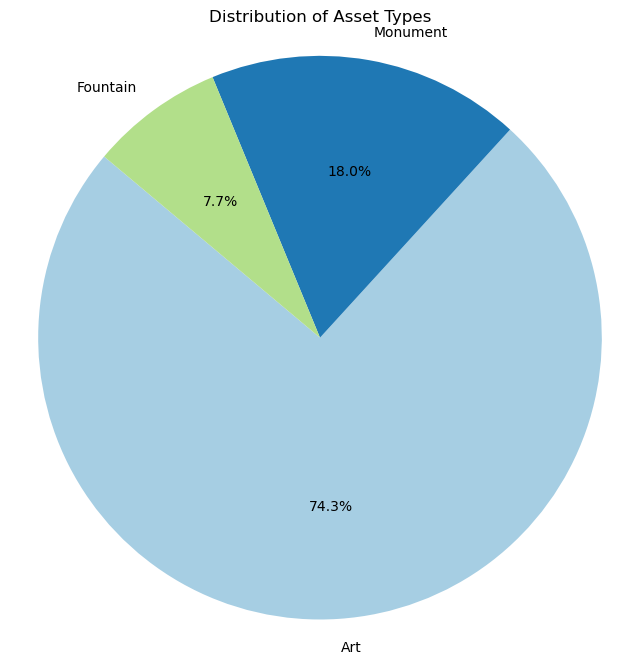

In [260]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count frequency of each Asset Type
asset_counts = places['Asset Type'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(asset_counts, labels=asset_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Asset Types')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

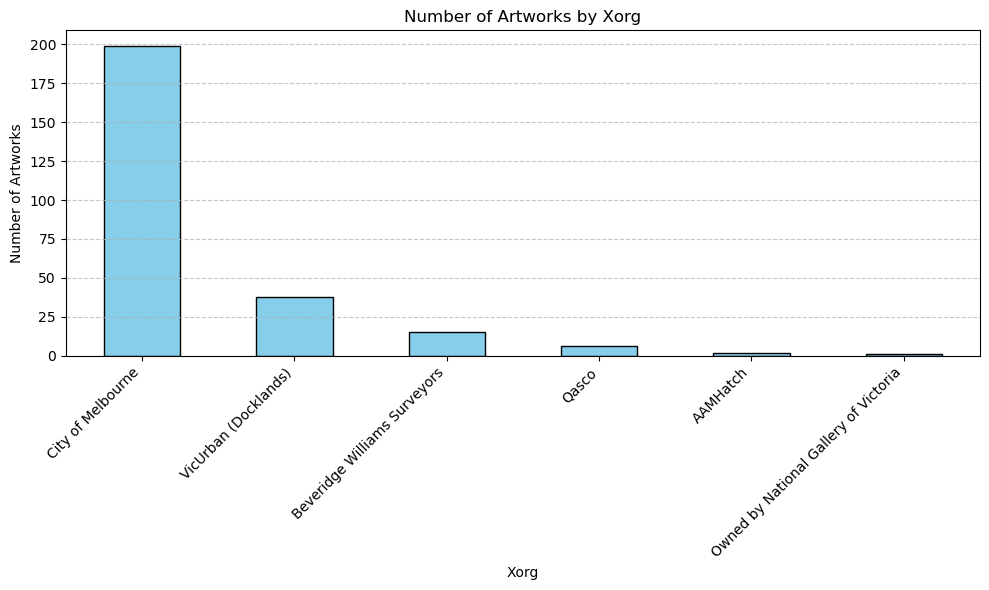

In [261]:
# Count frequency of each Xorg
xorg_counts = places['Xorg'].value_counts()

# Plot bar chart
plt.figure(figsize=(10, 6))
xorg_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of Artworks by Xorg')
plt.xlabel('Xorg')
plt.ylabel('Number of Artworks')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

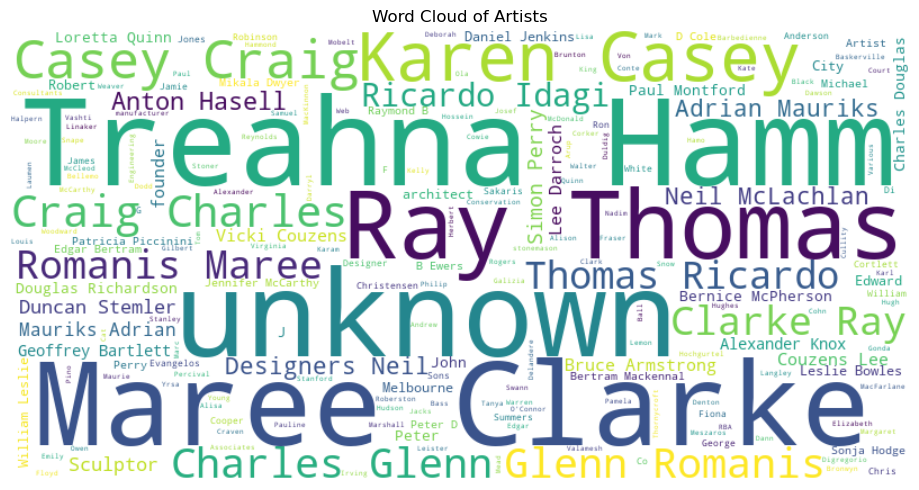

In [262]:
from wordcloud import WordCloud

# Drop NaN values from 'Artist' column
artists = places['Artist'].dropna()

# Combine all artist names into a single string
artist_text = " ".join(artists)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(artist_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Artists')
plt.tight_layout()
plt.show()

In [263]:
import pandas as pd
import folium

# Convert 'Co-ordinates' column to separate latitude and longitude
places[['Latitude', 'Longitude']] = places['Co-ordinates'].str.split(',', expand=True)
places['Latitude'] = places['Latitude'].astype(float)
places['Longitude'] = places['Longitude'].astype(float)

# Define color mapping for different Asset Types
asset_colors = {
    "Art": "blue",
    "Monument": "green",
    "Sculpture": "purple",
    "Panel": "orange"
}

# Create a base map centered on Melbourne
m = folium.Map(location=[-37.81, 144.96], zoom_start=13)

# Add markers with detailed tooltip
for _, row in places.iterrows():
    asset_type = row['Asset Type']
    color = asset_colors.get(asset_type, "gray")  # Default color if type is missing

    # Construct the tooltip with bold labels
    tooltip = f"""
    <b>Asset Type:</b> {row['Asset Type']}<br>
    <b>Name:</b> {row['Name']}<br>
    <b>Organization:</b> {row['Xorg']}<br>
    <b>Artist:</b> {row['Artist']}<br>
    <b>Year:</b> {row['Art Date']}
    """

    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Name'],
        tooltip=tooltip,
        icon=folium.Icon(color=color)
    ).add_to(m)

# Display the map
m
